In [2]:
# To push the split for training and developing data faster
# we need to skip the index when the timeline is not continuous. (This is covered by dropping all na values)
# The problem arise when there is not enough data after skipping.
# When that happen, the program skip again, leaving some valuable data behind.
# The best thing that can happen is when we skip the second time, if the timeline is not continuous, it will skip
# to the earliest not continous timeline. If we doesn't have any marker, we must find it manually by looping each index.
# So we need to have a marker. It will be put in the raw data files.

# Put timeskip marker in the raw datafiles. (New columns name Timeskip, value is the first time data appear again after the index)
# If after the skip, the timeline is not continous, find the time skip marker and put the position there.
# The refined file doesn't have data in PM (Missing data -> np.nan), findout why *** Not Done 2018 have some problem
# The split for training and developing data has index out of bound, fix it.
# The split for target have some difficulty:
# we can't shift the data so we have to merge it with splitting training data
# When splitting the data 


# We don't need to remove the data, we can just calculate like normal.
# Then in the finished file, we drop all data which deemed Missing. 
# When putting data to the model, we need to figure out a way to know which data is dropped


In [1]:
# !pip install --upgrade sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import holidays
plt.style.use('seaborn-darkgrid')
import joblib

In [2]:
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

root_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/'
_thudohanoi_data_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data'
_thudohanoi_files = glob.glob(_thudohanoi_data_path + '/*.csv')

thudohanoi_df = pd.DataFrame()
for file in _thudohanoi_files:
    print('Currently processing file \n{}'.format(file))
    thudohanoi_df = thudohanoi_df.append(pd.read_csv(file, parse_dates=True, index_col=['site_id', 'time'],
                                                    dtype={'CO': np.float64, 'NO2': np.float64,'PM25': np.float64,
                                                          'AQI_h': np.float64, 'AQI_h_I': np.int, 'site_id': np.int}))
    
# Remove site 16 because of some inconsistency in data
hanoi_df = thudohanoi_df[(thudohanoi_df.index.get_level_values(0) != 49)].copy()
hcm_df = thudohanoi_df[(thudohanoi_df.index.get_level_values(0) == 49)].copy()

Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/30.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/9.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/32.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/11.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/40.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/28.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/49.csv
Currently processing file 
/

In [3]:
def extract_time_features(df):
    # Job: Expand time in data
    time_index = df.index.get_level_values(1)
    df_time_features = pd.DataFrame()
    df_time_features['Hour'] = time_index.hour.astype(float)
    df_time_features['Month'] = time_index.month.astype(float)
    df_time_features['Day of Week'] = time_index.dayofweek.astype(float)
    df_time_features['Day of Month'] = time_index.day.astype(float)
    df_time_features['Days in Month'] = time_index.daysinmonth.astype(float)
    df_time_features['Year'] = time_index.year.astype(float)

    # Job: Encode time cyclical data
    hour_in_day = 23
    df_time_features['sin_hour'] = np.sin(2*np.pi*df_time_features['Hour']/hour_in_day)
    df_time_features['cos_hour'] = np.cos(2*np.pi*df_time_features['Hour']/hour_in_day)
    month_in_year = 12
    df_time_features['sin_month'] = np.sin(2*np.pi*df_time_features['Month']/month_in_year)
    df_time_features['cos_month'] = np.cos(2*np.pi*df_time_features['Month']/month_in_year)
    day_in_week = 6
    df_time_features['sin_dayweek'] = np.sin(2*np.pi*df_time_features['Day of Week']/day_in_week)
    df_time_features['cos_dayweek'] = np.cos(2*np.pi*df_time_features['Day of Week']/day_in_week)
    df_time_features['sin_daymonth'] = np.sin(2*np.pi*df_time_features['Day of Month']/df_time_features['Days in Month'])
    df_time_features['cos_daymonth'] = np.cos(2*np.pi*df_time_features['Day of Month']/df_time_features['Days in Month'])
    # One hot encode year data
    one_hot_df = pd.get_dummies(df_time_features['Year'], drop_first=True, prefix='year')
    df_time_features = df_time_features.join(one_hot_df)
    # Input weekday/weekend/holiday data
    vn_holidays = np.array(list(holidays.VN(years=[2015,2016,2017,2018,2019,2020,2021]).keys()))
    holiday_mask = np.isin(time_index.date, vn_holidays)
    masks = (holiday_mask) | (df_time_features['Day of Week'].values == 5) | (df_time_features['Day of Week'].values == 6)
    df_time_features['day_off'] = np.where(masks == True, 1, 0)
    df_time_features = df_time_features.drop(columns=['Day of Month', 'Month', 'Day of Week', 'Days in Month', 'Year', 'Hour'])
#     Input lagged data
    windows = list(range(1,13))
    windows.append(24)
    for window in windows:
        feature = 'AQI_h'
        series_rolled = df['AQI_h'].rolling(window=window, min_periods=0)
        series_mean = series_rolled.mean().shift(1).reset_index()
        series_std = series_rolled.std().shift(1).reset_index()
        df_time_features[f"{feature}_mean_lag{window}"] = series_mean['AQI_h'].values
#         df_time_features[f"{feature}_std_lag{window}"] = series_std['AQI_h'].values
        df_time_features.fillna(df_time_features.mean(), inplace=True)
        df_time_features.fillna(df['AQI_h'].mean(), inplace=True)

    return df_time_features.values, df_time_features.columns

def add_features(df):

    # Change all data to numpy, then concatenate those numpy.
    # Then construct the dataframe to old frame. This can work
    data_df = df[['AQI_h']].copy()

    # Job: Normalize train data

    scaler = MinMaxScaler(feature_range=(-1,1))

    for col in ['AQI_h']:
        data_df[[col]] = scaler.fit_transform(data_df[[col]])

    columns = ['site_id', 'time', 'AQI_h']
    df_numpy = data_df.reset_index().to_numpy()

    # Add onehot site label
    one_hot_site = pd.get_dummies(data_df.index.get_level_values(0), prefix='site', drop_first=True).astype(int)
    columns.extend(one_hot_site.columns)
    # Add onehot air category
    one_hot_cat = pd.get_dummies(df['AQI_h_I'], drop_first=True, prefix='cat').astype(int)
    columns.extend(one_hot_cat.columns)
    # Add time features
    time_features, time_columns = extract_time_features(data_df)
    columns.extend(time_columns)
    df_numpy = np.concatenate([df_numpy, one_hot_site.values, one_hot_cat.values, time_features], axis=1)
    

    final_df = pd.DataFrame(df_numpy, columns=columns).set_index(['site_id', 'time'])
    for float_col in final_df.loc[:, final_df.dtypes == float].columns:
        final_df.loc[:, float_col] = final_df.loc[:, float_col].values.round(6)
    return final_df
def generate_train_test_set_by_time(df, site='hcm' ,ratio = 0.1):
    # Generate test set by taking the lastest 10% data from each site
    if site=='hanoi':
        train_df = df[df.index.get_level_values(0) != 48]
        latest_time = train_df.index.get_level_values(1).max()
        oldest_time = train_df.index.get_level_values(1).min()
        cutoff_hour = (latest_time - oldest_time).total_seconds()
        cutoff_hour = cutoff_hour // 3600
        cutoff_hour = cutoff_hour * ratio
        test_df = train_df[train_df.index.get_level_values(1) >= (latest_time - pd.Timedelta(hours=cutoff_hour))]
        train_df = train_df[train_df.index.get_level_values(1) < (latest_time - pd.Timedelta(hours=cutoff_hour))]
        # Generate train_test set for site 48
        train_df_48 = df[df.index.get_level_values(0) == 48]
        latest_time = train_df_48.index.get_level_values(1).max()
        oldest_time = train_df_48.index.get_level_values(1).min()
        cutoff_hour = (latest_time - oldest_time).total_seconds()
        cutoff_hour = cutoff_hour // 3600
        cutoff_hour = cutoff_hour * ratio
        test_df = test_df.append(train_df_48[train_df_48.index.get_level_values(1) >= (latest_time - pd.Timedelta(hours=cutoff_hour))])
        train_df = train_df.append(train_df_48[train_df_48.index.get_level_values(1) < (latest_time - pd.Timedelta(hours=cutoff_hour))])
    elif site=='hcm':
        train_df = df.copy()
        latest_time = train_df.index.get_level_values(1).max()
        oldest_time = train_df.index.get_level_values(1).min()
        cutoff_hour = (latest_time - oldest_time).total_seconds()
        cutoff_hour = cutoff_hour // 3600
        cutoff_hour = cutoff_hour * ratio
        test_df = train_df[train_df.index.get_level_values(1) >= (latest_time - pd.Timedelta(hours=cutoff_hour))]
        train_df = train_df[train_df.index.get_level_values(1) < (latest_time - pd.Timedelta(hours=cutoff_hour))]
    return train_df, test_df
def generate_data_label(df):
    data = df.copy()
    label = df.AQI_h.copy()
    site_ids = data.index.get_level_values(0).unique()
    columns_data = data.columns
    for site in site_ids:
        data.loc[data.index.get_level_values(0) == site] = data[data.index.get_level_values(0) == site][:-1]
        label.loc[label.index.get_level_values(0) == site] = label[label.index.get_level_values(0) == site].shift(-1)
    data = data.dropna()
    label = label.dropna()
    data['label'] = label
    return data
def convert_types_hcm(df):
    converted_df = df.copy()
    int_columns = ['cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'year_2017.0',
                   'year_2018.0', 'year_2019.0', 'year_2020.0', 'year_2021.0', 'day_off']
    float_columns = ['AQI_h', 'sin_hour', 'cos_hour',
       'sin_month', 'cos_month', 'sin_dayweek', 'cos_dayweek', 'sin_daymonth',
       'cos_daymonth', 'AQI_h_mean_lag1', 'AQI_h_mean_lag2', 'AQI_h_mean_lag3',
       'AQI_h_mean_lag4', 'AQI_h_mean_lag5', 'AQI_h_mean_lag6',
       'AQI_h_mean_lag7', 'AQI_h_mean_lag8', 'AQI_h_mean_lag9',
       'AQI_h_mean_lag10', 'AQI_h_mean_lag11', 'AQI_h_mean_lag12',
       'AQI_h_mean_lag24', 'label']
    converted_df[int_columns] = converted_df.loc[:,int_columns].astype(int)
    converted_df[float_columns] = converted_df.loc[:,float_columns].astype(float)
    return converted_df
def convert_types_hanoi(df):
    converted_df = df.copy()
    int_columns = ['site_7', 'site_8', 'site_9', 'site_10', 'site_11', 'site_12',
                   'site_13', 'site_14', 'site_15', 'site_16', 'site_24', 'site_25',
                   'site_26', 'site_27', 'site_28', 'site_29', 'site_30', 'site_31',
                   'site_32', 'site_33', 'site_34', 'site_35', 'site_36', 'site_37',
                   'site_38', 'site_39', 'site_40', 'site_41', 'site_42', 'site_43',
                   'site_44', 'site_45', 'site_46', 'site_47', 'site_48', 'cat_2.0',
                   'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'year_2016.0', 'year_2017.0',
                   'year_2018.0', 'year_2019.0', 'year_2020.0', 'year_2021.0', 'day_off']
    float_columns = ['AQI_h', 'sin_hour', 'cos_hour',
       'sin_month', 'cos_month', 'sin_dayweek', 'cos_dayweek', 'sin_daymonth',
       'cos_daymonth', 'AQI_h_mean_lag1', 'AQI_h_mean_lag2', 'AQI_h_mean_lag3',
       'AQI_h_mean_lag4', 'AQI_h_mean_lag5', 'AQI_h_mean_lag6',
       'AQI_h_mean_lag7', 'AQI_h_mean_lag8', 'AQI_h_mean_lag9',
       'AQI_h_mean_lag10', 'AQI_h_mean_lag11', 'AQI_h_mean_lag12',
       'AQI_h_mean_lag24', 'label']
    converted_df[int_columns] = converted_df.loc[:,int_columns].astype(int)
    converted_df[float_columns] = converted_df.loc[:,float_columns].astype(float)
    return converted_df
def generate_data_to_model(df, site='hanoi'):
    df_train, df_test = generate_train_test_set_by_time(df, site=site)
    df_train, df_valid = generate_train_test_set_by_time(df_train, site=site)
    features = df_train.columns
    features = features[:-1]
    X_train, y_train = df_train[features], df_train.label
    X_valid, y_valid = df_valid[features], df_valid.label
    X_test, y_test = df_test[features], df_test.label
    return X_train, y_train, X_valid, y_valid, X_test, y_test, features
def write_and_plot_result(model, X_test, y_test, scaler, model_type):
    if model_type == 'auto_arima':
        transformed_predict = model.predict(n_periods=len(X_test), exogenous=X_test)
    else:
        transformed_predict = model.predict(X_test)
    transformed_predict = hanoi_scaler.inverse_transform(transformed_predict.reshape(-1,1))
    transformed_test = scaler.inverse_transform(y_test.values.reshape(-1,1))
    
    # Write result
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from math import sqrt

    rmse_xgboost = mean_squared_error(transformed_predict,transformed_test, squared=False)
    mae_xgboost = mean_absolute_error(transformed_predict,transformed_test)
    r2_xgboost = r2_score(transformed_predict,transformed_test)
    print("R2: {} / RMSE: {} / MAE: {}".format(r2_xgboost, rmse_xgboost, mae_xgboost))
    
    # Plot model
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot()
    ax.plot(transformed_test.reshape(-1,1), label='label')
    ax.plot(transformed_predict.reshape(-1,1), label='predict')
    fig.legend()
    plt.show()
    return None

In [4]:
hanoi_scaler = MinMaxScaler(feature_range=(-1,1))
hanoi_scaler.fit(hanoi_df[['AQI_h']])
hcm_scaler = MinMaxScaler(feature_range=(-1,1))
hcm_scaler.fit(hcm_df[['AQI_h']])

MinMaxScaler(feature_range=(-1, 1))

In [5]:
series_hanoi = add_features(hanoi_df).copy()
series_hanoi = generate_data_label(series_hanoi)
series_hanoi = convert_types_hanoi(series_hanoi)

series_hcm = add_features(hcm_df).copy()
series_hcm = generate_data_label(series_hcm)
series_hcm = convert_types_hcm(series_hcm)

In [7]:
X_train, y_train, X_valid, y_valid, X_test, y_test, features = generate_data_to_model(series_hanoi, site='hanoi')

In [9]:
result_df = pd.DataFrame()

<a id="subsection-eight"></a>
# AUTO ARIMA

In [10]:
! pip install pmdarima
import pmdarima as pm

In [1]:
model_pmdarima = pm.auto_arima(y=y_train.values, exogenous=X_train, trace=2, n_jobs=-1, stepwise=True)
model_pmdarima.fit(y_train, exogenous=X_train)

forecast = model_pmdarima.predict(n_periods=len(X_valid), exogenous=X_valid)
result_df["ARIMAX_AQI"] = forecast

NameError: name 'pm' is not defined

In [ ]:
joblib.dump(model_pmdarima, 'auto_arima.pkl')

In [ ]:
write_and_plot_result(model_pmdarima, X_test, y_test, hanoi_scaler, model_type='auto_arima')

In [ ]:
result_df["Forecast_ARIMAX"].plot(figsize=(16, 9))

In [ ]:
result_df[["Forecast_ARIMAX", "AQI_h"]].plot(figsize=(16, 9))

In [94]:
df_train = series_hanoi_train
df_valid = series_hanoi_valid
df_test = series_hanoi_test

<a id="subsection-eight"></a>
# RANDOM FOREST REGRESSOR

In [28]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor()
params={
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "min_samples_split": [1, 3, 4, 5, 6, 7],
 "min_samples_leaf" : [1, 3, 4, 5, 6, 7]
}
model_rnd  = GridSearchCV(    
                rnd_reg,
                param_grid=params,
                n_jobs=-1,
                cv=5,
                verbose=3,
)
model_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 33.8min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 3, 4, 5, 6, 7],
                         'min_samples_split': [1, 3, 4, 5, 6, 7]},
             verbose=3)

R2: 0.9291583095813067 / RMSE: 10.968522904676458 / MAE: 5.825121253058297


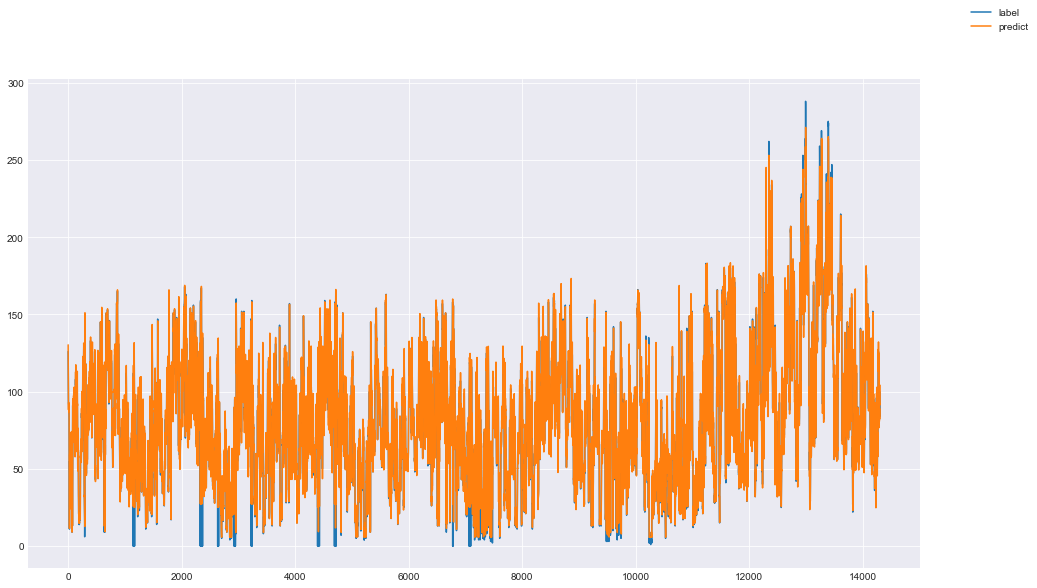

In [8]:
model_rnd = joblib.load('./hanoi_reg_models/rnd_model.pkl')
write_and_plot_result(model_rnd, X_test, y_test, hanoi_scaler, model_type="none")

R2: 0.9084739568266861 / RMSE: 9.178729109383204 / MAE: 6.475862700911222


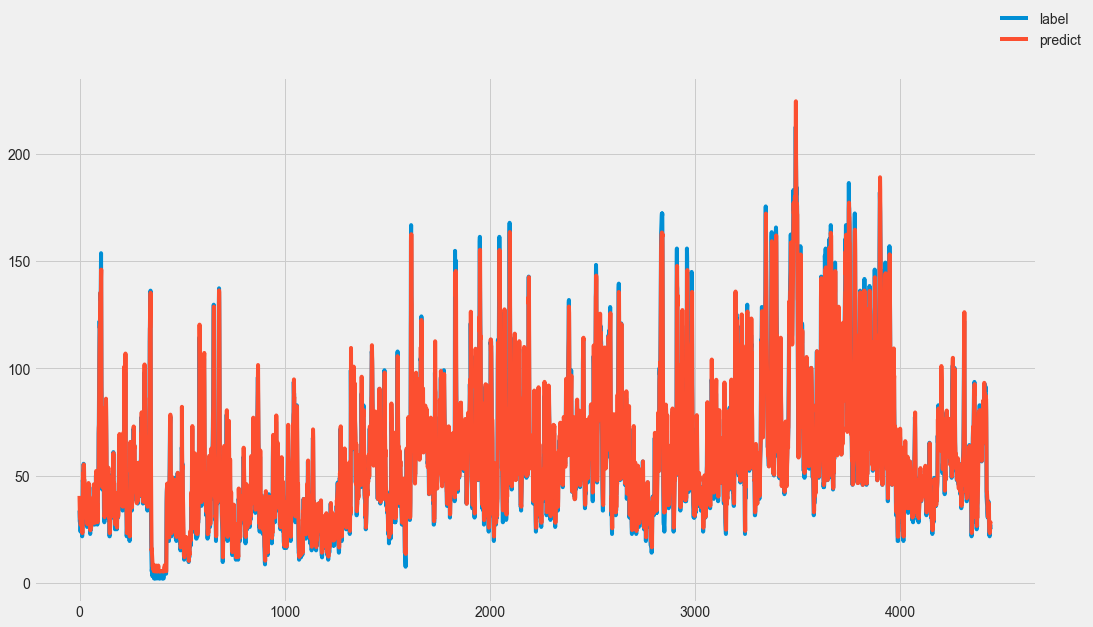

['rnd_model.pkl']

In [29]:
write_and_plot_result(model_rnd, X_test, y_test, hcm_scaler, model_type="none")
joblib.dump(model_rnd, 'rnd_model.pkl')

<a id="subsection-eight"></a>
# CART

In [30]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [31]:
tree_reg = tree.DecisionTreeRegressor()

In [32]:
## Hyper Parameter Optimization Grid

params={
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "min_samples_split": [1, 3, 4, 5, 6, 7],
 "min_samples_leaf" : [1, 3, 4, 5, 6, 7]
}

In [19]:
best_params_hanoi={'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

In [20]:
tree_reg = tree.DecisionTreeRegressor(**best_params)

In [33]:
model_CART  = GridSearchCV(    
                tree_reg,
                param_grid=params,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [34]:
model_CART.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   41.1s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 3, 4, 5, 6, 7],
                         'min_samples_split': [1, 3, 4, 5, 6, 7]},
             verbose=3)

In [21]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=5, min_samples_split=3)

R2: 0.9256597466373377 / RMSE: 11.254368442981766 / MAE: 6.253160350917473


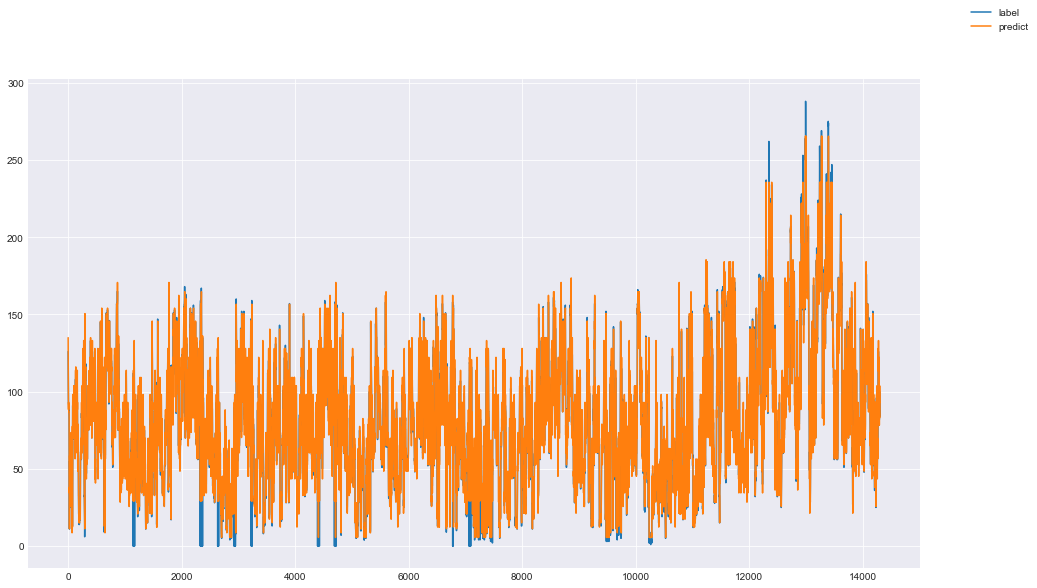

In [9]:
tree_reg = joblib.load('./hanoi_reg_models/cart_model.pkl')
write_and_plot_result(tree_reg, X_test, y_test, hanoi_scaler, model_type="none")

R2: 0.8852233621267809 / RMSE: 10.287723278545705 / MAE: 7.72434412493274


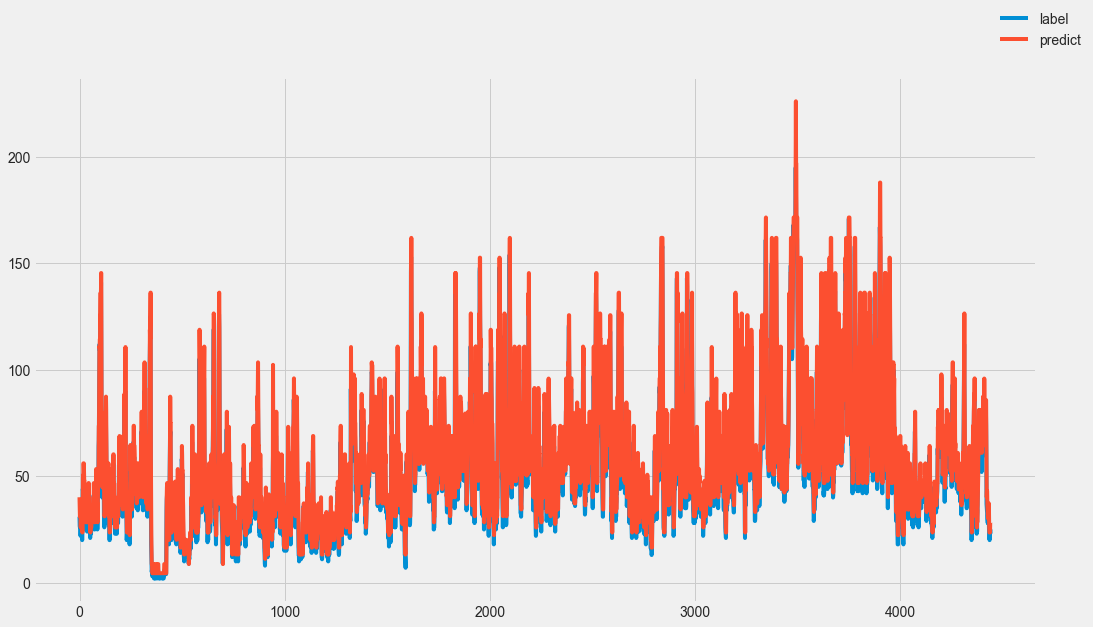

In [51]:
joblib.dump(model_CART, 'cart_model.pkl')
write_and_plot_result(model_CART, X_test, y_test, hcm_scaler, model_type='none')

In [39]:
print(f"Model Best Score : {model_CART.best_score_}")
print(f"Model Best Parameters : {model_CART.best_estimator_.get_params()}")

Model Best Score : 0.8970930932034344
Model Best Parameters : {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


<a id="subsection-eight"></a>
# XG Boost

In [40]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.style.use('fivethirtyeight')

from datetime import datetime

In [41]:
reg = xgb.XGBRegressor()

In [42]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [43]:
model_xgboost  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [44]:
model_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.8min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                 

In [49]:
import joblib
joblib.dump(model_xgboost, 'xgboost_model.pkl')
loaded_model = joblib.load("xgboost_model.pkl")

R2: 0.9291632901785305 / RMSE: 10.932723125685456 / MAE: 5.777621128599296


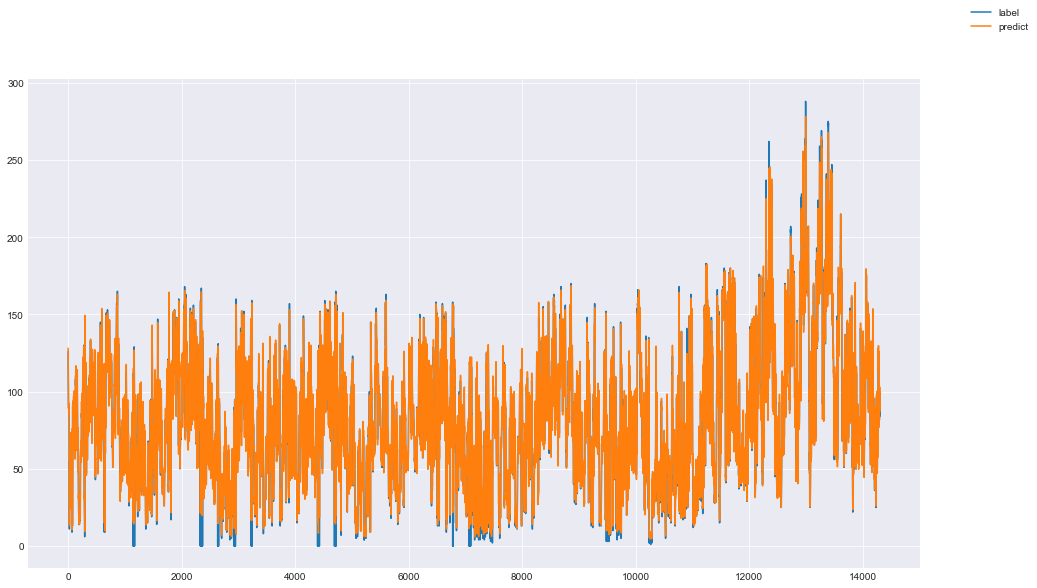

In [10]:
model_xgboost = joblib.load('./hanoi_reg_models/xgboost_model.pkl')
write_and_plot_result(model_xgboost, X_test, y_test, hanoi_scaler, model_type='none')

In [184]:
f = open('xg_models.txt'.format(root_path, str(np.datetime64('today', 'D'))), 'w')
f.write("Model Best Score : {}".format(model_xgboost.best_score_))
f.write("Model best param: {}".format(model_xgboost.best_estimator_.get_params()))
f.close()

AttributeError: 'RandomizedSearchCV' object has no attribute 'save_model'

In [185]:
print(f"Model Best Score : {model_xgboost.best_score_}")
print(f"Model Best Parameters : {model_xgboost.best_estimator_.get_params()}")

Model Best Score : 0.977294299919319
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.1, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 13, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1577, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
